# OpenAI Gymnasium Lab
<a href="https://gymnasium.farama.org/">OpenAI Gymnasium</a>

The OpenAI Gymnasium is a reinforcement learning playground, with MDP problems ranging from simple to complicated single agent environments. The following report has been prepared by Cameron Braatz as an academic project for CSPB 3202: Intro to Artificial Intelligence at CU-Boulder.

***
## Exploring the Environment
For this project, I decided to go with **Mountain Car** from the **Classic Control** library. According to the documentation, the Mountain Car MDP is a deterministic problem that sees a cart placed stochastically at the bottom of a sinusoidal valley.

<a href="https://gymnasium.farama.org/environments/classic_control/mountain_car/">OpenAI Gym: Mountain Cart</a>

### Import Gymnasium
Import OpenAI Gymnasium and specify the library of choice using `.make()`:

In [1]:
# import gymnasium as gym
import gym
env = gym.make('MountainCar-v0')


The possible actions are limited to accelerating left or right, while the cart is underpowered to the point of not being able to make a direct ascent. Instead, the MDP must strategically accelerate the car to reach the goal state at the top of the hill on the right side. With a basic introduction out of the way, lets get started.

In [2]:
print("State Space: ", env.observation_space)

State Space:  Box([-1.2  -0.07], [0.6  0.07], (2,), float32)


Breaking this down, we see that our state space consists of two numbers. The space is continuous and represents the **position** and **velocity** of our cart. Breaking the state space down further, we get:

In [3]:
print("Upper Bounds: ", env.observation_space.high)
print("Lower Bounds: ", env.observation_space.low)

Upper Bounds:  [0.6  0.07]
Lower Bounds:  [-1.2  -0.07]


### Observation Space
The **observation space** of this MDP is in the form of a `ndarray` with shape $(2,)$ with elements corresponding to:

|Num|Observation|Min|Max|Unit|
|---|-----------|---|---|----|
|0|Position of cart along the x-axis|-1.2|0.6|position (m)|
|1|Velocity of cart|-0.07|0.07|velocity (v)|

In plain terms, the carts position falls between $-1.2 < m < 0.6$ while its velocity falls between $-0.07 < v < 0.07$. Orientation and velocity vectors are oriented in the traditional left-to-right fashion (ie: negative values-left, positive values-right).

The starting state is initialized with the cart being dropped randomly between $-0.6 < m < -0.4$ with velocity $v=0$. Thus, begining more or less at the base of the valley at a stand-still.

### Action Space

In [4]:
print(env.action_space)

Discrete(3)



The **action space** consists of three (3) discrete deterministic actions:

|Num|Action|
|---|------|
|0|Accelerate to the left|
|1|No Acceleration|
|2|Accelerate to the right|

### Transition Dynamics
Given an action, the cart responds with the following transition dynamics:

$\text{velocity}_{t+1} = \text{velocity}_t + (\text{action} - 1) * \text{force} - cos(3 * \text{position}_t) * \text{gravity}$<br>
$\text{position}_{t+1} = \text{position}_t + \text{velocity}_{t+1}$

where; $\text{force} = 0.001$ and $\text{gravity} = 0.0025$

In the event of a collision at either end, the actions are **inelastic** (ie: velocity set to zero (0)).

### Reward
The goal of the MDP is to reach the flag at the top of the hill on the right side, *as quickly as possible*. To incentivize immediate action, a *negative* reward of -1 is deducted for each timestep. There is no established reward for completion, nor any penalties for completely ascending the left hill.

### Terminal State
The **Mountain Car** MDP terminates upon two conditions:
- Terminal State: The cart reaches the goal state, top of the right hill
    - ie: $m \geq 0.5$
- Truncation: The MDP has timed out
    - ie: length of episode exceeds 200 timesteps

## Interacting with the Environment
The initiate our MDP, run `env.reset()` which returns our environments initial state.

In [5]:
# initiate new environment...
observation = env.reset()
print("Observation: ", observation)

Observation:  (array([-0.44809836,  0.        ], dtype=float32), {})


In order for the agent to act, we need to choose an action. For the sake of getting more familiar with the environment, the code block below leverages `env.action_space.sample()` to randomly select an action and apply it.

We begin from starting state and apply five (5) random actions, plotting the resulting state variables at each step. Finishing out our preliminary investigating by closing out of the environment.

In [6]:
for i in range(1,6):
    # sample action at random...
    action = env.action_space.sample()
    print("\tAction: ", action)

    # unpack environment tuple into its respective variables...
    observation, reward, isEnd, timeOut, info = env.step(action)
    print("Step {} Results:".format(i))
    print("\tObservation: ", observation)
    print("\tReward: ", reward)
    print("\tTerminated: ", isEnd)
    print("\tTruncated: ", timeOut)
    print("\tInfo: ", info)

env.close()

	Action:  1
Step 1 Results:
	Observation:  [-0.4486598  -0.00056142]
	Reward:  -1.0
	Terminated:  False
	Truncated:  False
	Info:  {}
	Action:  0
Step 2 Results:
	Observation:  [-0.45077854 -0.00211874]
	Reward:  -1.0
	Terminated:  False
	Truncated:  False
	Info:  {}
	Action:  0
Step 3 Results:
	Observation:  [-0.4544391  -0.00366056]
	Reward:  -1.0
	Terminated:  False
	Truncated:  False
	Info:  {}
	Action:  0
Step 4 Results:
	Observation:  [-0.45961463 -0.00517555]
	Reward:  -1.0
	Terminated:  False
	Truncated:  False
	Info:  {}
	Action:  2
Step 5 Results:
	Observation:  [-0.46426713 -0.00465248]
	Reward:  -1.0
	Terminated:  False
	Truncated:  False
	Info:  {}


c:\Users\camer\Documents\CU-Boulder\CSPB 3202 - Artificial Intelligence\Final Project\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


***
## Building the Agent
With the *Histopathological Cancer Detection* project, I opted to use PyTorch as my Machine Learning library. For this project, I will use TensorFlow for comparison sake. Before we begin, lets import the packages we will need to train this MDP problem. The first code block pulls in our standard libraries as well as our TensorFlow library, setting some default matplotlib standards for use later on.

The matplotlib styling/animation and preliminary working model architecture was shaped by the work of John King, specifically their model for a TensorFlow neural network to solve this MDP. It seems that their specific implementation is depricated by the latest version of Mountain Car, which made for quite the process of bringing it back into working order.

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from collections import deque

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

### Agent Class Definition
The code below defines a **Deep Q-Network (DQN)** agent class which implements our basic reinforcement learning model. It is designed to interact with an unknown environment, learn from its experiences and improve it's policy over time.

#### Initialization
The `__init__()` method initializes our DQN agent, complete with all the materials it will need.
- `gamma`: Discount factor; determines how much to discount future rewards, lower values prioritize immediate rewards over distant ones
- `batch_size`: The number of experiences sampled from replay memory for each training step
- `state_size`: The dimensionality of the state space (ie: number of state variables)
- `action_size`: Number of possible actions the agent can take (ie: three (3) in our case)
- `episodes`: Total number of episodes to train the agent
- `replay_memory`: A deque (ie: doubly ended queue) storing the last 2000 experiences of format (state, action, reward, next_state, done)
- `optimizer`: Adam optimizer that adjusts the model's weights based on gradients
- `loss_fn`: Loss function; in our case this implements mean-squared-error (MSE), ie: difference between predicted and target Q-values

#### Building the Model
The `build_model()` method leverages TensorFlow's Keras, a machine learning/deep learning API, to construct the neural network. It is sequentially built with:
- Input Layer: A dense (fully connected) layer with 32 neurons and ReLU activation, takes `state_size` as input
- Hidden Layer: A second dense layer with 32 neurons and ReLU activation
- Output Layer: A third dense layer with each neuron representing an available action, specifically its Q-value

#### Storing/Accessing Memories
The key aspect of reinforcement learning is an agents ability to recall and 'learn' from it's past experiences. The next couple methods make this possible; `add_memory()` and `sample_experiences()` store past experiences and sample them.

The former simply applies some type checking before appending a tuple, formatted as *(state, action, reward, next_state, done)*, into the memory deque defined earlier. 

The latter randomly generates a list of indices, of length equal to the batch size, with which we  sample the collected deque of experiences. It uses nested **list comprehension** to extract each of the five (5) aformentioned tuple values for each of the experiences in the batch. Before returning, it reshapes both `states` and `next_states` before returning a tuple formatted, *(states, actions, rewards, next_states, dones)*.

#### Training the Model
Beginning with unpacking the tuple from the `sample_experiences()` class function, we use the TensorFlow Keras `predict` method to predict the model's next state's Q-values. From which the max Q-value (ie: best action) is used to solve a Bellman Equation to find our target Q-value for non-terminal states.

The model creates a mask to collect the Q-value corresponding to the action taken with `tf.one_hot()`. The `tf.GradientTape()` utility tracks all operations for TensorFlow to use in calculating gradients, with respect to the loss function. The Q-values mask is applied to our models `state` class variable to form a tensor, with each element corresponding to a particular action in that state (row=state,column=action).

Reducing a given state's row in the tensor returns the sum of its values, but given this tensor was one hot encoded this isolates the Q-value of the taken action. While the loss function computes the loss (ie: MSE in our case) between predicted and target Q-values. At which point, the gradients are computed and applied to adjust the weights and biases of our network.

In [8]:
import tensorflow as tf
import numpy as np
import gym
from collections import deque

class DQNagent:
    def __init__(self, state_size, action_size, episodes):
        self.gamma = 0.95
        self.batch_size = 64
        self.state_size = state_size
        self.action_size = action_size
        self.episodes = episodes
        self.replay_memory = deque(maxlen=2000)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.loss_fn = tf.keras.losses.MeanSquaredError()

    def build_model(self):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(32, activation="relu", input_shape=[self.state_size]),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dense(self.action_size)
        ])
        return model

    def add_memory(self, state, action, reward, next_state, done):
        done = float(done)  # Ensure done is a float
        self.replay_memory.append((state, action, reward, next_state, done))

    def sample_experiences(self):
        indices = np.random.randint(len(self.replay_memory), size=self.batch_size)
        batch = [self.replay_memory[index] for index in indices]
        states, actions, rewards, next_states, dones = [
            np.array([experience[field_index] for experience in batch])
            for field_index in range(5)]
        states = states.reshape(self.batch_size, self.state_size).astype(np.float32)
        next_states = next_states.reshape(self.batch_size, self.state_size).astype(np.float32)
        return states, actions, rewards, next_states, dones

    def train_model(self, model):
        states, actions, rewards, next_states, dones = self.sample_experiences()
        next_Q_values = model.predict(next_states)
        max_next_Q_values = np.max(next_Q_values, axis=1)
        target_Q_values = rewards + (1 - dones) * self.gamma * max_next_Q_values
        mask = tf.one_hot(actions, self.action_size)
        with tf.GradientTape() as tape:
            all_Q_values = model(states)
            Q_values = tf.reduce_sum(all_Q_values * mask, axis=1)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))
        grads = tape.gradient(loss, model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

### Reward Shaping
The original method for reinforcement rewards were to verify an action is in unison to the direction the agent is travelling. This does result in learning, *eventually*, but by improving on our reward function we can hopefully accelerate learning.

Building from this original logic, we can add additional incremental rewards such as:
- Penalty for Inaction
    - *Any* movement is good movement in this MDP
    - Penalize inaction (ie: action=1) to discourage this behavior
- Reward for Goal State
    - Obviously the agent should be getting a relatively large reward for finding the goal state
- Penalty for Timing Out
    - If the agent fails to find the goal state, that episode must be deemed a failure
- Reward for Moving Right
    - While only moving right will not reach the goal state, we do want our agent to push right
    - Give a modest reward for any movement to the right
    - Note: this reward is unique to this MDP, remove for dynamic environments
- Reward for Acting Parallel to Velocity
    - Original logic is used, just with a slightly larger reward
- Penalty for Acting Opposite to Velocity
    - MDP must conserve momentum to reach the top of the hill
    - Acting opposite current momentum is harmful and should be discouraged
- Reward for Acceleration
    - Increasing velocity is critical to reaching the top of the hill, give relatively large reward
    - No penalty should apply to deceleration as this is necessary for switching directions

The methods above are applied *in addition* to the timestep reward (-1) to maintain the incentive for finding the goal state in less steps.

In [9]:
def rewardShaping(next_state, state, action, done, timeout):
    position, velocity = next_state[0]
    prev_position, prev_velocity = state[0]
    reward = 0

    if done:
        reward += 100

    if timeout:
        reward -= 1

    if action == 1:
        reward -= 1

    # reward for moving towards goal state...
    if position > prev_position:
        reward += 1

    # reward for any movement matching the action specified...
    if position - prev_position > 0 and action == 2:
        reward += 1
    elif position - prev_position < 0 and action == 0:
        reward += 1
    '''
    # penalize any action opposite the current motion...
    if position - prev_position > 0 and action == 0:
        reward -= 10
    elif position - prev_position < 0 and action == 2:
        reward -= 10
    '''
    # reward acceleration in any direction...
    if velocity > prev_velocity and action == 2: # if accelerating right w/ action = right...
        reward += 1
    elif abs(velocity) < abs(prev_velocity) and action == 0: # if accelerating left w/ action = left...
        reward += 1

    return reward

The reward shaping outlined above aimed to improve the learning rate of the model, but never proved consistently fruitful as outlined above. I reason that the ambiguity of the environment and the complexity of the first iteration of the reward shaping proved to contradict itself and hinder effective learning.

Instead, a simpler reward shaping structure proved to be more reliable in implementation. Simply rewarding for moving in the direction of the agent's current motion and a larger reward for finding the goal state. The most effective implementation I was able to find can be seen below:

In [10]:
def rewardShaping(next_state, state, action, done, timeout):
    position, velocity = next_state[0]
    prev_position, prev_velocity = state[0]

    # reward for any movement matching the action specified...
    if position - prev_position > 0 and action == 2:
        reward = 1

    elif position - prev_position < 0 and action == 0:
        reward = 1

    if done:
        reward = 10

    return reward

### Training Loop
The meat and potatoes of the training method relies on our training loop; executing numerous episodes, each complete with 200 timesteps to gain experiences interacting with the environment.

#### Initialization
Before looping begins, the following variables must be defined:
- `best_score`: Default score set at the max timestep count to guarantee score improvement with policy improvement
- `episodes`: Declaring the number of training episodes to train on, sets number of iterations on the outer loop
- `env`: Generates the default environment space for `MountainCar-v0`
- `state_size`: Determines the size of the state space, in our case this is position and velocity (2)
- `action_size`: Determines the size of the action space, in our case this is push left/right and no push (3)
- `agent`: Iniltializes a DQN agent  to our state size, action size and number of episodes
- `model`: Builds the neural network model for the agent to use in predicting Q-values
- `rewards`: Initializing an empty array to store the number of steps (or rewards) per episode

#### Episode Loop
Assuming $n$ episodes were declared, this loop iterates from 1 through $n+1$. At each step it resets the environment, simulating a wiping the slate clean and beginning in a new environment once again. Before initiating the inner step loop, the state data is reshaped to the required neural network formatting. 

An additional *optional* print statement was placed to track the model's progression through training cycles.

#### Step Loop
The *Mountain Cart* environment dictates that each episode consist of 200 timesteps, which is the set number of iterations for this inner loop.

The loop begins by determining a dynamically derived `epsilon` value, designed to encourage exploration in earlier episodes while encouraging exploitation in the latter stages of training. To ensure the logic does not explicitly follow that pattern, a random comparison to our `epsilon` value determines whether to *explore* or *exploit*; choosing an action at random or choosing an action based on our predicted Q-values.

Once an action has been selected, we use it to calculate our next environment state and reshape it before applying our rewards shaping. The rewards are then used to add this environment step to our memory array, transition the **current state** into the **next state** and break out of the step loop if the goal state has been reached.

#### Episode Completion/Model Training
With each episode completion the reward is added to our rewards array, and if a better score is found; the weights and score are updated. While the model begins training the model after completion of 50 episodes, to ensure that a good bank of memories are established before the agent starts acting on them.

Once the two loops have completed, our best weights are set in our model and the environment is closed...completing the training session.

In [11]:
import tensorflow as tf
import numpy as np
import gym
from collections import deque
from tqdm import tqdm

class DQNagent:
    def __init__(self, state_size, action_size, episodes):
        self.gamma = 0.95
        self.batch_size = 64
        self.state_size = state_size
        self.action_size = action_size
        self.episodes = episodes
        self.replay_memory = deque(maxlen=2000)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.loss_fn = tf.keras.losses.MeanSquaredError()

    def build_model(self):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(32, activation="relu", input_shape=[self.state_size]),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dense(self.action_size)
        ])
        
        return model

    def add_memory(self, state, action, reward, next_state, done):
        done = float(done)  # Ensure done is a float
        self.replay_memory.append((state, action, reward, next_state, done))

    def sample_experiences(self):
        indices = np.random.randint(len(self.replay_memory), size=self.batch_size)
        batch = [self.replay_memory[index] for index in indices]
        states, actions, rewards, next_states, dones = [
            np.array([experience[field_index] for experience in batch])
            for field_index in range(5)]
        states = states.reshape(self.batch_size, self.state_size).astype(np.float32)
        next_states = next_states.reshape(self.batch_size, self.state_size).astype(np.float32)
        return states, actions, rewards, next_states, dones

    def train_model(self, model, episode):
        states, actions, rewards, next_states, dones = self.sample_experiences() 
        next_Q_values = model.predict(next_states, verbose=0)
        max_next_Q_values = np.max(next_Q_values, axis=1)
        target_Q_values = rewards + (1 - dones) * self.gamma * max_next_Q_values
        mask = tf.one_hot(actions, self.action_size)
        with tf.GradientTape() as tape:
            all_Q_values = model(states)
            Q_values = tf.reduce_sum(all_Q_values * mask, axis=1)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))
        grads = tape.gradient(loss, model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

### Prioritized Sampling
The original sampling technique used an algorithm to generate simple random indices, regardless of their weight/impact on the agent's performance. The following code block are two simple implementations of a **prioritized indexing** algorithm.

Instead, this approach creates a copy of the memory array into a list to be sorted based on its reward. Depending on which direction the list is sorted, the algorithm chooses the percentage beneath the split by front/back indexing with the remaining values are chosen at random. Unfortunately, I have not fully gotten this implemented in the source code at the time of writing this, so long as it remains incomplete; simple random sampling will be used.

In [12]:
def pick_priority(split):
    test = []
    test = np.arange(0,20)
    test = np.sort(test)
    
    goal = []
    index = int(split * len(test))
    print("{} index is: {}".format(split,index))

    goal = [i for i in test[:index]]
    new = np.random.choice(test[:len(test)],len(test)-index,replace=False).tolist()

    return goal + new

result = pick_priority(0.25)
print("pick_priority: {}, length: {}".format(result, len(result)))

def priority_index(split,length):
    index = int(split * length)
    print("{} index is: {}".format(split,index))
    
    priority = np.arange(length-index,length).tolist()
    random = np.random.randint(0,length-index,length-index).tolist()

    return priority + random

result = priority_index(0.25,20)
print("pick_priority: {}, length: {}".format(result, len(result)))

0.25 index is: 5
pick_priority: [0, 1, 2, 3, 4, 13, 5, 4, 3, 9, 11, 12, 10, 14, 19, 2, 7, 8, 16, 0], length: 20
0.25 index is: 5
pick_priority: [15, 16, 17, 18, 19, 7, 11, 12, 9, 7, 12, 14, 11, 13, 7, 10, 3, 8, 14, 12], length: 20


***
## Final Model Definition and Training
The following code blocks follows the same pattern and parameter definitions as explained above, just with the set of definitions that I ultimately settled on for my final iteration of this model. I plan to revisit this with more time; tieing up lose ends and continuing to refine the model's performance.

In [13]:
import tensorflow as tf
import numpy as np
import gym
from collections import deque
from tqdm import tqdm

class DQNagent:
    def __init__(self, state_size, action_size, episodes):
        self.gamma = 0.95
        # increased batch size to gain more potential...
        self.batch_size = 256
        self.state_size = state_size
        self.action_size = action_size
        self.episodes = episodes
        # increase max length of replays for more potential for rewards...
        self.replay_memory = deque(maxlen=5000)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.loss_fn = tf.keras.losses.MeanSquaredError()

    def build_model(self):
        '''
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(32, activation="relu", input_shape=[self.state_size]),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dense(self.action_size)
        ])
        '''
        # opted for more complex neural network than initially implemented...
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(64, activation="relu", input_shape=[self.state_size]),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dense(self.action_size)
        ])
        
        return model

    # add memory to replay_memory array...
    def add_memory(self, state, action, reward, next_state, done):
        done = float(done)  # Ensure done is a float
        self.replay_memory.append((state, action, reward, next_state, done))

    # randomly sample experiences from memory...
    def sample_experiences(self):
        indices = np.random.randint(len(self.replay_memory), size=self.batch_size)
        batch = [self.replay_memory[index] for index in indices]
        states, actions, rewards, next_states, dones = [
            np.array([experience[field_index] for experience in batch])
            for field_index in range(5)]
        states = states.reshape(self.batch_size, self.state_size).astype(np.float32)
        next_states = next_states.reshape(self.batch_size, self.state_size).astype(np.float32)
        return states, actions, rewards, next_states, dones
    
    # attempt at implementation of priority selection, issues handling complex deque data structure...
    def pick_priority(self,split,sort):
        # deque has no efficient sorting method, attempted incremental/partial sorting methods...
        if sort:
            replay_list = list(self.replay_memory)
            print("replay_list: ", replay_list)

            new_list = replay_list.sort(key = lambda x: x.index(2))
            self.sorted_memory = new_list
            print("replay_memory: ",self.replay_memory)
            print("sorted_memory: ",new_list)
        else:
            replay_list = self.sorted_memory

        size = self.batch_size
        split = int(split * size)

        # use a split to direct index top value memories and combine with random ones...
        priority = np.arange(size-split, size).tolist()
        random = np.random.randint(0,len(self.replay_memory)-split, (size-split)).tolist()

        batch_indices = priority + random

        # same zipping and reshaping approach used in random sampling...
        batch = [replay_list[index] for index in batch_indices]
        states, actions, rewards, next_states, dones = [
            np.array([experience[field_index] for experience in batch])
            for field_index in range(5)]
        
        states = states.reshape(self.batch_size, self.state_size).astype(np.float32)
        next_states = next_states.reshape(self.batch_size, self.state_size).astype(np.float32)

        return states, actions, rewards, next_states, dones

    def train_model(self, model, episode):
        '''
        # mixed priority and random experience selection, split parameter dictates ratio...
        if episode % 50 == 0:
            states, actions, rewards, next_states, dones = self.pick_priority(split=0.25,sort=True)
        else:
            states, actions, rewards, next_states, dones = self.pick_priority(split=0.25)
        '''
        # simple random experience selection...
        states, actions, rewards, next_states, dones = self.sample_experiences()
        
        next_Q_values = model.predict(next_states, verbose=0)
        max_next_Q_values = np.max(next_Q_values, axis=1)
        target_Q_values = rewards + (1 - dones) * self.gamma * max_next_Q_values
        mask = tf.one_hot(actions, self.action_size)
        with tf.GradientTape() as tape:
            all_Q_values = model(states)
            Q_values = tf.reduce_sum(all_Q_values * mask, axis=1)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))
        grads = tape.gradient(loss, model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
best_score = 200
episodes = 1500

env = gym.make('MountainCar-v0')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNagent(state_size, action_size, episodes)
model = agent.build_model()
rewards = []
steps = []

# set range starting at 1 through 200 (inclusive) to prevent 'improving' best score on time out...
for episode in range(1,episodes+1):
    #print("Episode {} starting now...".format(episode))
    state = env.reset()[0]
    state = state.reshape(1, -1)
    
    for step in range(1,201):
        epsilon = max(1 - episode/(episodes*0.8), 0.01)
        if np.random.rand() < epsilon: 
            action = np.random.randint(action_size)
        else: 
            q_values = model.predict(state, verbose=0)
            action = np.argmax(q_values[0])
        
        next_state, reward, done, timeout, info = env.step(action)
        next_state = next_state.reshape(1, -1)

        #points, delta = rewardMotion(next_state,state)

        #reward = reward + points
        #reward = reward + rewardAcceleration(next_state,state,delta)

        '''
        if next_state[0][0] - state[0][0] > 0 and action == 2:
            reward = 1
        if next_state[0][0] - state[0][0] < 0 and action == 0:
            reward = 1
        #if next_state[0][1] > state[0][1]:
            #reward = 2

        if done: 
            reward = 10
        '''
        reward = rewardShaping(next_state,state,action,done,timeout)
        #print("Reward: {}".format(reward))
        
        agent.add_memory(state, action, reward, next_state, done)
        state = next_state.copy()
        
        if done:
            break

    rewards.append(step)
    
    if step < best_score:
        best_weights = model.get_weights()
        best_score = step
    
    print("\rEpisode: {}/{}, Best Score: {}, eps: {:.3f}".format(episode, episodes, best_score, epsilon), end="")
    
    if episode > 50:
        agent.train_model(model,episode)

model.set_weights(best_weights)

env.close()

***
## Visualizing Model Performance
The following graph plots the rewards array across the extent of our training episodes. This notebook only shows the current model's performance here, but a summary of attempts are logged at the end of the notebook for reflection/analysis.

In earlier iterations, our score reflected the number of steps it took to complete an episode. Using this logic, the model remained unchanged at the max number of steps until it was able to find the goal state. At which point, the model increasingly kept finding the goal...albeit falling repeatedly between improved results and the max number of steps. This trend, referred to as *catastrophic forgetting*, is not reliably effective in training the model.

In latter iterations, the score reflects the rewards from each episode. Using this logic, the graph looks entirely different but allows the agent to learn more from the incremental rewards and less from the overall number of steps to reach the goal (this incentive is covered by a sub-one valued gamma).

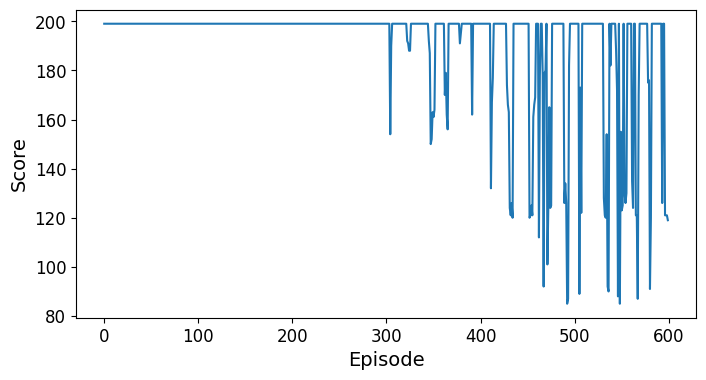

Best Score:  85


In [53]:
plt.figure(figsize=(8,4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.show()

print("Best Score: ", min(rewards))

### Rendering Agent Policy
The following code block is minimally modified from the work of John King; which collects the agent's policy, simulates it in a fresh environment and tracks it for rendering/animating.

Since this portion of the project is more about rendering and less about the training methodology, the explanation will be less verbose. That said, the steps in doing so are as follows:
#### Policy Simulation
- Initialization:
    - An empty `frames` array is created for storing our model data at each timestep
    - The environment is created and seeds are implemented to ensure reproducible conditions across our environment and random library
    - The environment is reset and the observation data is reshaped before moving into step iteration
- Policy Simulation:
    - Running for the `n_max_steps` value of 200, this loop simulates a single episode
    - The rendered environment is captured as an RGB array and appended to our `frames` array
    - The next `action` is predicted according to our model and is executed, returning the standard environment output
    - The loop breaks early if the goal state is reached before the time limit
    - Once complete, the environment is closed and the `frames` array is returned

#### Policy Animation
- The plot figure is generated and formatted
- A matplotlib animation module is leveraged to bring our `frames` array to life
- Returning an animation for replaying/rendering for human eyes

In [15]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Video

def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make('MountainCar-v0', render_mode='rgb_array')
    env.reset(seed=seed)
    np.random.seed(seed)
    obs, _ = env.reset()  # Unpack the tuple
    obs = obs.reshape(1, -1)  # Ensure correct shape
    
    for step in range(n_max_steps):
        frame = env.render()  # Ensure the frame is returned as RGB array
        if frame is None:
            print("Warning: Frame is None")
            continue
        frames.append(frame)
        obs = obs.reshape(1, -1)  # Ensure correct shape
        action = np.argmax(model.predict(obs, verbose=False)[0])
        obs, reward, done, timeout, info = env.step(action)
        obs = obs.reshape(1, -1)  # Ensure correct shape

        if done:
            break
    
    env.close()
    return frames

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close(fig)
    return anim

# Example usage
frames = render_policy_net(model)

# Debug print to check the data type of frames
print(f"Frame type: {type(frames[0])}, Frame dtype: {frames[0].dtype}")

# Convert frames to the correct dtype if necessary
frames = [np.array(frame) for frame in frames]

plot_animation(frames)

NameError: name 'model' is not defined

***
# Reflection/Results
Accessing more impactful memories. Random is great, but would it maybe be good to store memories in a heap or BST to grab the highest and lowest valued memories?

Attempts were made to optimize the model, but I am still unsure if there is a good way to simplify this problem for iterative testing/development. It seems that with only 200 timesteps in an episode, it is very unlikely a naive agent would find the goal state in any given episode. This necessitates the need for training sessions with such large episode counts that iterative algorithm development is not effective.

With more time (or a much more powerful machine), I would like to revisit this and further tweak the model parameters and reward shaping algorithms.

## Summary of Model Improvement
### Preliminary Model
Across 50 episodes; with a reward for motion *in any direction* resulting in a reward of 1. In hindsight, this result was *incredibly* lucky and was in no way recreatable across another training session with such a small number of episodes.

!["v1.1"](assets/v1.1.png)

Best Score: 119 timesteps

Best Policy:<br>

In [16]:
from IPython.display import Video
Video("./assets/Attempt1.mp4")

### Increased Reward Shaping
Across 50 episodes; with a reward for motion *in any direction* resulting in a reward of 15. While the rewards were increased, the short training session failed to find the goal state during this attempt.

!["v1.2"](assets/v1.2.png)

Best Score: 199 Timesteps

#### Continued Increased Reward Shaping
Across 50 episodes; with a reward for motion *in any direction* for a reward of 1, with another reward of increasing value awarded for **acceleration** *in any direction*...determined if the current position delta (ie: change in position) is larger than the previous states position delta.

!["v1.3"](assets/v1.3.png)

It was at this point that it became clear that the initial attempt got *extremely* lucky in finding a successful path to the goal state, as this cannot reliably be reproduced despite increasing the rewards/incremental reward structure. For the next few iterations, I plan to adjust the model architecture specifically. As well as increasing the number of training episodes to allow the model more time to converge, unfortunately this means significantly longer training periods.

Best Score: 199 Timesteps

### Increasing Training Duration
I returned to the basic rewards pattern this time across 600 attempts, just to be sure I didn't break something in my model...allowing the original behaviour to recreate the learning from our preliminary attempt. To my pleasure, this model developed a successful policy to solve the MDP in 85 timesteps.

!["v2.0"](assets/v2.0.png)

Best Score: 85 Timesteps

Best Policy:<br>

In [17]:
Video("./assets/Attempt2.mp4")

#### Revisiting Reward Shaping
I attempted to integrate the custom rewards shaping across 1000 episodes, to unpromising results. It was at this point I realized that my approach for reward shaping was too complex for this environment. Providing too much direction, *especially* contradicting reward/penalty will cancel out the intended reinforcement.

Future attempts focus on a simple approach to reward shaping and increased focus on model architecture and sampling techniques.

!["v2.1"](assets/v2.1.png)

Best Score: 199 Timesteps

Best Policy:<br>

In [18]:
Video("./assets/Attempt3.mp4")

### Adjusting Batch Size
At this point, I began experimenting with increasing my batch size to cast a broader net onto my available memories...originally set at 64. I first ruled out using a smaller batch size, something that worked well in binary image classification, to no noticeable impact.

The original attempt with a batch size of 32 did find the goal state, but the random sampling failed to recognize this in further learning moments and that policy never gained traction. Increasing the gamma value to 1.0 also seemed to have little impact on the performance of the model either.

!["v2.2.png"](./assets/v2.2.png)

I ran this next model across 600 episodes; with the original simple rewarding, a batch size of 256, deque of 5000, and a gamme of 0.95. While this change yielded more reliably positive results, it still struggled to maintain consistent performance. Alternating between solving the MDP with results around 90, and failing to find a valid policy.

Additionally, it was bugging me that the original model defaulted to a best score of 199 timesteps when it failed to find the goal state, despite running a full 200 timesteps. This was simply an *off by one* error with the `step` loop, setting the range to start at 1 instead of 0 corrected this issue (see following attempt for implementation). Below you can see the results of the resolution of the indexing error and the newly modified model parameters:

!["v2.3.png"](./assets/v2.3.png)

In [19]:
Video("./assets/Attempt4.mp4")


### Increasing Training Duration and Model Complexity
Given the hit-or-miss performance across the 600 episode training sessions, I decided to settle into larger episode counts to ensure the model had plenty of time to:
1) Find the goal state
2) Develop enough positive reinforcements to sample from
3) Converge on a valid policy

I began experimenting with episode counts of *at least* 1000; typically using 1000 and 1500 for testing purposes. That said, this came at the cost of diminished exploratory model manipulation as the time to run training sessions began to increase substantially.

This model ran across 1000 episodes; with the original simple rewarding, a batch size of 256, deque of 5000, and a gamma of 0.95. Additionally, I have added more neural network layers to increase the network complexity (also increasing training time), but with the benefit of substantially more consistent policy convergence. 

The previous model definition can be seen below, followed immediately by its successor:

```
# original model architecture definition...
model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(32, activation="relu", input_shape=[self.state_size]),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dense(self.action_size)
        ])
```
```
# successor model architecture definition...
model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(64, activation="relu", input_shape=[self.state_size]),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dense(self.action_size)
        ])
```

!["v2.4.png"](./assets/v2.4.png)

Best Score: 89 Timesteps

In [20]:
Video("./assets/Attempt5.mp4")

Note that at this point, we have started to see that our model converges on reasonably effective policies. This is indicated on the graph above by increasingly diverging from the `best_score` value of 200 on the y-axis. The model has jumps of learning, with less frequent degradation of performance (ie: jumping back to 200 timestep performances). 

Since no random seed is being provided this model, we can alternatively run our model consecutively using the same parameters/model architecture and see how it performs on a fresh environment. In this case, the second session found the goal state around episode 400 and converged on a relatively effective policy across the next 600 episodes. The results can be seen below:

!["v2.5.png"](./assets/v2.5.png)

Best Score: 84 Timesteps

In [21]:
Video("./assets/Attempt6.mp4")

### Model Convergence
same as 12 but with memory deque of 5000, episodes 1500, score 83

Given the success of increasing the training period, I wanted to continue down this path now that reasonable policy convergence is being seen. As expected, the model again finds a solution around episode 400 with a relatively effective policy convergence around episode 1000. Notably, the next 500 iterations effectively diverge our model's policy from producing policies that would result in failure to find the flag (ie: max timestep of +/- 160).

!["v3.0.png"](./assets/v3.0.png)

In [22]:
Video("./assets/Attempt7.mp4")

## Reflection
In reflection, I found that reward shaping was an effective but complicated endeavor to get just right with the Mountain Cart MDP problem. I found myself wasting a lot of time attempting to iteratively improve my model's performance through reward shaping, despite using a model whose training duration failed to find a solution in most cases.

While this approach was good in trouble shooting code implementations, it was not a very informative approach to designing, validating and implementing this model. What did yield positive results was settling into a simplistic reinforcement rewarding approach while exploring different model architectures, parameter sets and training durations. 

I simply ran out of time to roll out a more nuanced reward shaping algorithm, which I would assume could rapidly increase the model's learning rate. My attempt at prioritized memory sampling was another effort I had to set aside due to time constraints. That being said, the model that I developed and trained is one that can consistently converge on a policy that solves the MDP. 

While my models get close to averaging under 100 timesteps (the threshold OpenAI deems this MDP 'solved'), they still fall slightly short given the training durations I used towards the end. I suspect with either an even longer training duration and/or the improvements in progress at the time of writing, the scores would fall under this threshold.

***
END OF REPORT

In [48]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make('MountainCar-v0', render_mode='rgb_array')
    env.reset(seed=seed)
    np.random.seed(seed)
    obs, _ = env.reset()  # Unpack the tuple
    obs = obs.reshape(1, -1)  # Ensure correct shape
    
    for step in range(n_max_steps):
        frame = env.render()  # Ensure the frame is returned as RGB array
        if frame is None:
            print("Warning: Frame is None")
            continue
        frames.append(frame)
        obs = obs.reshape(1, -1)  # Ensure correct shape
        action = np.argmax(model.predict(obs)[0])
        obs, reward, done, timeout, info = env.step(action)
        obs = obs.reshape(1, -1)  # Ensure correct shape

        if done or timeout:
            break
    
    env.close()
    return frames

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close(fig)
    return anim

# Example usage
frames = render_policy_net(model)

# Debug print to check the data type of frames
print(f"Frame type: {type(frames[0])}, Frame dtype: {frames[0].dtype}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

In [49]:
# Convert frames to the correct dtype if necessary
frames = [np.array(frame) for frame in frames]

plot_animation(frames)

# Previous Code Drafts

In [ ]:
import tensorflow as tf
import numpy as np
import gym
from collections import deque

class DQNagent:
    def __init__(self, state_size, action_size, episodes):
        self.gamma = 0.95
        self.batch_size = 64
        self.state_size = state_size
        self.action_size = action_size
        self.episodes = episodes
        self.replay_memory = deque(maxlen=2000)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.loss_fn = tf.keras.losses.MeanSquaredError()

    def build_model(self):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(32, activation="relu", input_shape=[self.state_size]),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dense(self.action_size)
        ])
        return model

    def add_memory(self, state, action, reward, next_state, done):
        done = float(done)  # Ensure done is a float
        self.replay_memory.append((state, action, reward, next_state, done))

    def sample_experiences(self):
        indices = np.random.randint(len(self.replay_memory), size=self.batch_size)
        batch = [self.replay_memory[index] for index in indices]
        states, actions, rewards, next_states, dones = [
            np.array([experience[field_index] for experience in batch])
            for field_index in range(5)]
        states = states.reshape(self.batch_size, self.state_size).astype(np.float32)
        next_states = next_states.reshape(self.batch_size, self.state_size).astype(np.float32)
        return states, actions, rewards, next_states, dones

    def train_model(self, model):
        states, actions, rewards, next_states, dones = self.sample_experiences()
        next_Q_values = model.predict(next_states, verbose=0)
        max_next_Q_values = np.max(next_Q_values, axis=1)
        target_Q_values = rewards + (1 - dones) * self.gamma * max_next_Q_values
        mask = tf.one_hot(actions, self.action_size)
        with tf.GradientTape() as tape:
            all_Q_values = model(states)
            Q_values = tf.reduce_sum(all_Q_values * mask, axis=1)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))
        grads = tape.gradient(loss, model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

best_score = 200
episodes = 600
env = gym.make('MountainCar-v0')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNagent(state_size, action_size, episodes)
model = agent.build_model()
rewards = []

for episode in range(episodes):
    state = env.reset()[0]
    state = state.reshape(1, -1)
    
    for step in range(200):
        epsilon = max(1 - episode/(episodes*0.8), 0.01)
        if np.random.rand() < epsilon: 
            action = np.random.randint(action_size)
        else: 
            q_values = model.predict(state, verbose=0)
            action = np.argmax(q_values[0])
        
        next_state, reward, done, timeout, info = env.step(action)
        next_state = next_state.reshape(1, -1)
        
        if next_state[0][0] - state[0][0] > 0 and action == 2: reward = 1
        if next_state[0][0] - state[0][0] < 0 and action == 0: reward = 1
        
        agent.add_memory(state, action, reward, next_state, done or timeout)
        state = next_state.copy()
        
        if done or timeout:
            break
    
    rewards.append(step)
    
    if step < best_score:
        best_weights = model.get_weights()
        best_score = step
    
    print("\rEpisode: {}, Best Score: {}, eps: {:.3f}".format(episode, best_score, epsilon), end="")
    
    if episode > 50:
        agent.train_model(model)

model.set_weights(best_weights)

env.close()

In [ ]:
import tensorflow as tf
import numpy as np
import gym
from collections import deque
from tqdm import tqdm

class DQNagent:
    def __init__(self, state_size, action_size, episodes):
        self.gamma = 0.95

        self.batch_size = 256
        
        self.state_size = state_size
        self.action_size = action_size
        self.episodes = episodes
        self.replay_memory = deque(maxlen=5000)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.loss_fn = tf.keras.losses.MeanSquaredError()

    def build_model(self):
        '''
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(32, activation="relu", input_shape=[self.state_size]),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dense(self.action_size)
        ])
        '''
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(64, activation="relu", input_shape=[self.state_size]),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dense(self.action_size)
        ])
        
        
        return model

    def add_memory(self, state, action, reward, next_state, done):
        done = float(done)  # Ensure done is a float
        self.replay_memory.append((state, action, reward, next_state, done))

    def sample_experiences(self):
        indices = np.random.randint(len(self.replay_memory), size=self.batch_size)
        batch = [self.replay_memory[index] for index in indices]
        states, actions, rewards, next_states, dones = [
            np.array([experience[field_index] for experience in batch])
            for field_index in range(5)]
        states = states.reshape(self.batch_size, self.state_size).astype(np.float32)
        next_states = next_states.reshape(self.batch_size, self.state_size).astype(np.float32)
        return states, actions, rewards, next_states, dones
    
    def pick_priority(self,split,sort=False):
        if sort:
            replay_list = list(self.replay_memory)
            replay_list = replay_list.sort(key = lambda x: x[2])

        size = self.batch_size
        split = int(split * size)

        priority = np.arange(size-split, size).tolist()
        random = np.random.randint(0,len(self.replay_memory)-split, size-split).tolist()

        batch_indices = priority + random

        batch = [self.replay_memory[index] for index in batch_indices]

        states, actions, rewards, next_states, dones = [
            np.array([experience[field_index] for experience in batch])
            for field_index in range(5)]
        
        states = states.reshape(self.batch_size, self.state_size).astype(np.float32)
        next_states = next_states.reshape(self.batch_size, self.state_size).astype(np.float32)

        return states, actions, rewards, next_states, dones

    def train_model(self, model, episode):
        if episode % 50 == 0:
            states, actions, rewards, next_states, dones = self.pick_priority(0.25,sort=True)
        else:
            states, actions, rewards, next_states, dones = self.pick_priority(0.25)
        next_Q_values = model.predict(next_states, verbose=0)
        max_next_Q_values = np.max(next_Q_values, axis=1)
        target_Q_values = rewards + (1 - dones) * self.gamma * max_next_Q_values
        mask = tf.one_hot(actions, self.action_size)
        with tf.GradientTape() as tape:
            all_Q_values = model(states)
            Q_values = tf.reduce_sum(all_Q_values * mask, axis=1)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))
        grads = tape.gradient(loss, model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, model.trainable_variables))